### Model Evaluation and Plotting

**Import packages**

In [1]:
import pandas as pd
from ftplib import FTP
from io import BytesIO
from pykrige.ok import OrdinaryKriging
import numpy as np
import plotly.graph_objects as go

**Load the data**

In [2]:
df_1 = pd.read_csv('../data/1961-1990.csv')

In [3]:
df_2 = pd.read_csv('../data/1991-2000.csv')

In [4]:
df_3 = pd.read_csv('../data/2001-2010.csv')

In [5]:
df_4 = pd.read_csv('../data/2011-2020.csv')

We are just looking at average winter termperatures, so let's get a quick statistical summary for each dataset. 

In [6]:
df_1['Tave_wt'].describe()

count    189.000000
mean      -8.039683
std        5.686636
min      -19.400000
25%      -12.000000
50%       -8.800000
75%       -4.000000
max        4.800000
Name: Tave_wt, dtype: float64

In [7]:
df_2['Tave_wt'].describe()

count    189.000000
mean      -7.000529
std        5.823599
min      -19.100000
25%      -10.900000
50%       -8.100000
75%       -2.400000
max        5.600000
Name: Tave_wt, dtype: float64

In [8]:
df_3['Tave_wt'].describe()

count    189.000000
mean      -6.158201
std        5.536167
min      -17.700000
25%       -9.900000
50%       -7.000000
75%       -2.300000
max        5.600000
Name: Tave_wt, dtype: float64

In [9]:
df_4['Tave_wt'].describe()

count    189.000000
mean      -5.886243
std        5.325962
min      -16.800000
25%       -9.500000
50%       -7.000000
75%       -2.300000
max        5.500000
Name: Tave_wt, dtype: float64

**Let's take a look at some dummy Kriged data.**
To do so, we need to install rasterio to read a raster file. 

In [10]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [12]:
import rasterio

# Load the .tiff file
with rasterio.open('../data/2011-2020-idw.tif') as src:
    kriged_values = src.read(1)


In [13]:
kriged_values

array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -2.5428038e+00, -3.5269425e+00, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       ...,
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03, -9.9990000e+03, -9.9990000e+03, ...,
        -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]])

In [14]:
kriged_values.dtype

dtype('float64')

In [15]:
kriged_values.shape

(43, 89)

The Kriged values are in the form of an array containing interpolated temperature values.

### Read in train and test data sets

In [16]:
y_train = pd.read_csv('../data/y_train.csv')
X_train = pd.read_csv('../data/X_train.csv')
y_test = pd.read_csv('../data/y_test.csv')
X_test = pd.read_csv('../data/X_test.csv')

In [17]:
X_test.head()

,Unnamed: 0,Latitude,Longitude
0,77,57.500000,-128.500000
1,26,56.016667,-120.616667
2,41,59.500000,-130.500000
3,4,58.400000,-134.700000
4,160,51.500000,-117.500000


In [18]:
X_train.head()

,Unnamed: 0,Latitude,Longitude
0,142,52.5,-125.5
1,172,50.5,-117.5
2,145,52.5,-122.5
3,80,57.5,-125.5
4,147,52.5,-120.5


In [19]:
y_test.head()

,Unnamed: 0,Tave_wt
0,77,-9.6
1,26,-10.4
2,41,-11.5
3,4,-2.7
4,160,-4.8


In [20]:
y_train.head()

,Unnamed: 0,Tave_wt
0,142,-7.1
1,172,-6.4
2,145,-6.1
3,80,-9.2
4,147,-8.0


**Next, we'll fit the Krigging model into the training data. But what are the best parameters?**

We will conduct a grid search to identify the best parameters. 

In [21]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.model_selection import GridSearchCV

from pykrige.rk import Krige

In [23]:
from sklearn.model_selection import GridSearchCV
from pykrige.rk import Krige

param_dict = {
    "method": ["ordinary","universal"],
    "variogram_model": ["linear", "power", "gaussian", "spherical", "exponential"],
    "nlags": [4, 6, 8],
    "weight": [True, False]
}

estimator = GridSearchCV(Krige(), param_dict, verbose=True, return_train_score=True)

# Extracting the feature matrix X
X = X_train[['Latitude', 'Longitude']].values

# Extracting the target variable y
y = y_train['Tave_wt'].values

# run the gridsearch
estimator.fit(X, y)

if hasattr(estimator, "best_score_"):
    print("best_score R² = {:.3f}".format(estimator.best_score_))
    print("best_params = ", estimator.best_params_)

print("\nCV results::")
if hasattr(estimator, "cv_results_"):
    for key in [
        "mean_test_score",
        "mean_train_score",
        "param_method",
        "param_variogram_model",
    ]:
        print(" - {} : {}".format(key, estimator.cv_results_[key]))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points wil

**Our results are the following**:
- best_score R² = 0.858
- best_params =  {'method': 'ordinary', 'nlags': 6, 'variogram_model': 'gaussian', 'weight': True}

Now that we have the best parameters, we will plug these into our Kriging model. 

In [24]:
best_model = estimator.best_estimator_

In [25]:
best_model

Krige(variogram_model='gaussian', weight=True)

In [26]:
from pykrige.ok import OrdinaryKriging

In [27]:
resolution = 0.5  # cell size in meters, smaller cell size = smaller pixel = higher resolution 
gridx = np.arange(X_train.Latitude.min(), X_train.Latitude.max(), resolution)
gridy = np.arange(X_train.Longitude.min(), X_train.Longitude.max(), resolution)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 31.791971947112494
Full Sill: 37.684865723330134
Range: 8.16349054689216
Nugget: 5.892893776217644 



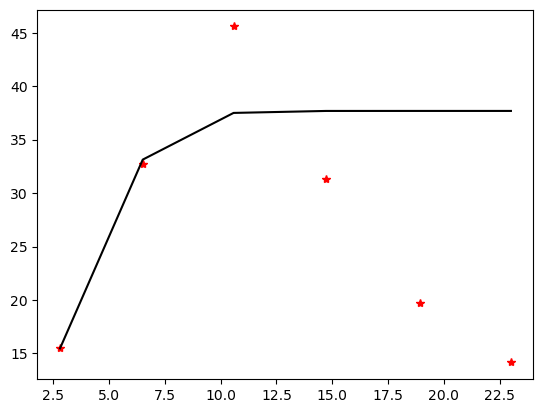

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [28]:
OK = OrdinaryKriging(
    X_train['Latitude'],
    X_train['Longitude'],
    y_train['Tave_wt'],
    variogram_model= "gaussian",# "spherical" "linear" "gaussian" "power" "exponential"
    verbose=True,
    nlags=6,
    weight=True,
    enable_plotting=True
)

z, ss = OK.execute("grid", gridx, gridy)

**Now let's make predictions on the test set.**

In [81]:
#define the coordinates of the locations in the test set 
latitude_pred = X_test['Latitude'].values
longitude_pred = X_test['Longitude'].values

#Use the fitted Kriging model to make predictions at the specified locations in the test set
z_pred, ss_pred = OK.execute('points', latitude_pred, longitude_pred)

#Store our predicted values
predicted_values = np.array(z_pred)

Executing Ordinary Kriging...



**Let's take a look at what our Ordinary Kriging model predicted.**

In [82]:
predicted_values

array([ -9.57844923,  -9.36586428, -13.68249219,  -3.72609014,
        -6.79319437,  -1.41236393,  -4.80115687, -10.91075943,
        -1.64007541,  -8.56997061, -13.32334385,  -2.88222353,
        -7.64372799, -13.56989298, -11.15799698,  -1.32636634,
        -8.1088173 ,  -6.17569297, -10.33533894,  -4.65194457,
        -0.47104619,  -6.64942368,   3.01248906,  -6.55828595,
        -8.21329563,  -3.34159435,  -6.32624765,  -7.41379934,
        -4.35914837, -12.47607362,  -2.65163531,  -8.21806381,
       -10.32475735,  -0.60151481,  -7.90270346,  -3.38725374,
       -11.63750717, -15.80429564])

**What were our actual values?**

In [31]:
actual_values = y_test['Tave_wt'].values
actual_values

array([ -9.6, -10.4, -11.5,  -2.7,  -4.8,  -1.1,  -3.4, -10.4,  -1.1,
        -8.8, -15.2,  -5.7,  -8.3, -10.3, -10.5,  -3.7,  -8.6,  -6.5,
       -11.3,  -5.5,   0. ,  -9.9,   3.5,  -5.5,  -7.6,  -5.2,  -7.6,
        -7.9,  -5.6, -11.7,  -5. , -10. ,  -8.5,  -1.5,  -7.2,  -3.9,
       -10. , -15.1])

**Next we calculate error**

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#calculate error metrics to evaluate the accuracy of the predictions
mse = mean_squared_error(actual_values, predicted_values)
print("Mean Squared Error:", mse)

Mean Squared Error: 2.12922993011801


In [38]:
#calculate error metrics to evaluate the accuracy of the predictions
rmse = mean_squared_error(actual_values, predicted_values, squared = False)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 1.459188106488677


In [39]:
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.196291514645126


**Let's plot our predicted against our true values.**

In [40]:
import matplotlib.pyplot as plt

In [124]:
from scipy.interpolate import griddata

# Define a grid for the test data
gridx_test = np.arange(X_test['Latitude'].min(), X_test['Latitude'].max(), resolution)
gridy_test = np.arange(X_test['Longitude'].min(), X_test['Longitude'].max(), resolution)
gridx_test, gridy_test = np.meshgrid(gridx_test, gridy_test)

# Interpolate the predicted values onto the grid
points = np.vstack((X_test['Latitude'], X_test['Longitude'])).T
z_pred_interpolated = griddata(points, predicted_values, (gridx_test, gridy_test), method='cubic')

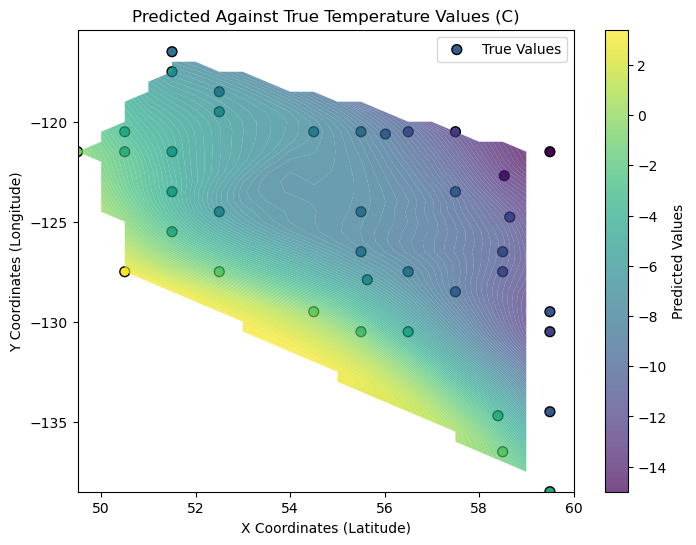

In [125]:
#Plot true values

plt.figure(figsize=(8, 6))

plt.scatter(X_test['Latitude'], X_test['Longitude'], c=actual_values, cmap='viridis', 
            label='True Values', marker='o', edgecolors='k', s=50)

#Plot predicted values as a contour layer
contour = plt.contourf(gridx_test, gridy_test, z_pred_interpolated, cmap='viridis', levels=100, alpha=0.7, antialiased=True)

#Add colour bar
cbar = plt.colorbar(contour, label='Predicted Values')

#Add labels and legend
plt.xlabel('X Coordinates (Latitude)')
plt.ylabel('Y Coordinates (Longitude)')
plt.legend()
plt.title('Predicted Against True Temperature Values (C)')

#Show the plot
plt.show()

From the graph, we can conclude that our predicted values (in the contour layer) align closely with the true values. 